<h1>The Movies Dataset</h1>
<h3>Overview</h3>
    
<p>This dataset is of ~45000 movies. Its data has been collected from IMDB. It collects attributes such as the budget, overview, popularity, revenue, title, production companies and countries, runtime, vote average, vote count and others for every movie in the dataset. The target attribute is created from the genres column, where the first genre of every movie is separated in a new column that eventually forms the target variable. The text data will be collected from the overview attribute column of the dataset. I will be trying to predict the genre of the movie based on the overview given for that movie.</p>

<h3>Business Case</h3>
<p>This could be the prototype for an actual model to classify the main genre of the movie based on the overview given. I think the classification task is interesting, albeit educational in nature. I think it is more interesting than the setiment analysis based on the reviews of the movies. Given a larger dataset of movies, I think the eventual learning model could become of usable accuracy, where genres would be generated for the movie based on what content is on the overview. I am using Recall for the evaluation metric. Considering the cost of misclassification of movie genres (no one is gonna die), 80% for micro recall seems like a reasonable threshold for the usability of the model in a real life application.</p>

<h3>List of Example Feature Columns</h3>

<ul>
    <li>Overview</li>
    <li>Genres</li>
    <li>Cast</li>
    <li>Crew</li>
    <li>Popularity</li>
    <li>Revenue</li>
    <li>Budget</li>
    <li>Production Companies</li>
    <li>Production Countries</li>
    <li>Vote Average</li>
    <li>Vote Count</li>
</ul>

<h1>Preparation</h1>
<h2>Definition of Dataset Variables</h2>

In [763]:
import pandas as pd
import numpy as np
import json
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
import json
import ast

<h3>Loading and Processing the Dataset</h3>

In [764]:
# Loading the movies dataset into a dataframe
dataframe = pd.read_csv("E:/ABDALLAH THE GREAT ENGINEER/Southern Methodist University/Coursework/Spring 2018/Machine Learning in Python/TMDB_5000/movies_metadata.csv")

C:\Users\abdallah.jabr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [765]:
# Removing irrelevant feature columns
for column in dataframe.columns:
    if ((column != 'overview') and (column != 'genres') and (column != 'id')):# and (column != 'keywords' and (column != 'original_title'))):
        dataframe = dataframe.drop(column, axis = 1)

In [766]:
# Dropping the Nan values
dataframe = dataframe.dropna(axis = 0, how='any')

In [767]:
# Casting as string
dataframe['overview'] = dataframe['overview'].astype(str)
dataframe['genres'] = dataframe['genres'].astype(str)

In [768]:
# Processing the genres column to extract the first genre into a separate column for every movie instance
dataframe.insert(column = 'genre', loc = 2, value = str)

In [769]:
# Extracting the genre from the genres column
for i in range(len(dataframe)):
    m = len(ast.literal_eval(dataframe.iloc[i, dataframe.columns.get_loc('genres')]))
    if (m > 0):
        dataframe.iloc[i, dataframe.columns.get_loc('genre')] =  ast.literal_eval(dataframe.iloc[i, dataframe.columns.get_loc('genres')])[0]['name']
    else:
        dataframe.iloc[i, dataframe.columns.get_loc('genre')] =  ''

In [774]:
# Removing unpopular genres
for gen in dataframe['genre']:
    if gen == '' or gen == 'Foreign' or gen == 'TV Movie' or gen == 'Aniplex'  or gen == 'Carousel Productions'  or gen == 'Odyssey Media':
        dataframe = dataframe.drop(dataframe[dataframe['genre']==gen]['id'].index)

# Removing the now irrelevant genres column        
dataframe = dataframe.drop('genres', axis = 1)

<h3>Final Dataset</h3>
<p>The final dataset, represented by the dataframe defined, has only two columns. The first, genre, represents the main genre of every movie in the dataset. The genre is the target variable I will be trying to classify in this lab assignment. The second column, overview, represents the text data that my RNNs are going to fit for classification.</p>

<h2>Validation</h2>

<h3>Evaluation Metric</h3>
<p>The code below shows the class balance of the dataset.</p>
<p>Since the data I am working with is heavily imbalanced, the Micro Recall is a good evaluation metric for my dataset. It is a good evaluation metric because I am concerned with my model's performance in classifying movies correctly, but I am also equally concerned with its inability to classify the movies when the prediction does not match the true class. The Recall metric defintion fits the task.</p>

In [775]:
labels = np.unique(dataframe['genre'])
print('The number of unique genres is', len(labels))

The number of unique genres is 18


In [776]:
for label in labels:
    print('The number of instances from the ', label, 'genre is: ', len(dataframe[dataframe['genre']==label]))

The number of instances from the  Action genre is:  4465
The number of instances from the  Adventure genre is:  1502
The number of instances from the  Animation genre is:  1114
The number of instances from the  Comedy genre is:  8517
The number of instances from the  Crime genre is:  1663
The number of instances from the  Documentary genre is:  3376
The number of instances from the  Drama genre is:  11804
The number of instances from the  Family genre is:  508
The number of instances from the  Fantasy genre is:  696
The number of instances from the  History genre is:  273
The number of instances from the  Horror genre is:  2612
The number of instances from the  Music genre is:  480
The number of instances from the  Mystery genre is:  547
The number of instances from the  Romance genre is:  1163
The number of instances from the  Science Fiction genre is:  639
The number of instances from the  Thriller genre is:  1646
The number of instances from the  War genre is:  373
The number of ins

<h3>Data Division</h3>
<p>
    <ul>
        <li>The dataset will be split according to 80/20 for training/testing after being <b>randomly shuffled</b>. An overview-based movie genre classifier will receive movies of random genres, so shuffle-splititng is appropriate for training/testing.</li>
        <li>Stratified K-Folding will be used on the 80% training dataset for cross validation. Stratified K-Folds are appropriate because I want to make sure that each fold is a perfect representative of the overall training dataset. This is important because I need to be able to compare the performance of different RNN models.</li>
        <li>Finally, the model with the best statistical quantities resulting from hyperparameter tuning will be tested using the 20% of testing data. Its performance in classifying those 20% of text sequeneces dictates its generalization performance.</li>
    </ul>
</p>

In [922]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<h1>Modeling</h1>

In [880]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers.embeddings import Embedding
from sklearn.metrics import recall_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn import metrics as mt
import itertools

<h2>Data Preprocessing</h2>
<p>Here I prepare the text data of my dataset (the movies' overviews) to be converted into sequences that Keras can deal with. This dataset has approximately 40,000 movies. I want to keep all words in the sequences, and so the top words parameter is chosen to be 80,000, which is about a 1000 words less than the actual top amount.</p>

<p>The maximum length of any overview is 187 words, which was checked before making it explicit. The top words and maximum oveview length parameters were made explicit because Tensorflow throws errors at me when I define them as None in the Keras objects. As mentioned before, I don't want to discard any data, as the classification task is not an easy one for this dataset; the models need all the help they can get.</p>

In [968]:
# The number of the words I keep. 
top_words = 80000
# Tokenizing the text into integer sequences for later Keras processing
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(dataframe['overview'].values)
sequences = tokenizer.texts_to_sequences(dataframe['overview'])
# Max length of overview. This is the actual maximum length of any overview instance
max_overview_length = 187

<h3>Padding of Sequences</h3>
<p>Here, the sequences are padded according to the maximum overview length, which is 187.</p>

In [969]:
# Padding according to the longest sequence
# Padding with value of zero
data = pad_sequences(sequences, maxlen = max_overview_length)

<h3>Encoding and One-Hot-Encoding</h3>
<p>Encoding the target into integers, followed by one-hot-encoding for later Modeling in Keras.</p>

In [970]:
# Label encoding the target variable
encoder = LabelEncoder()
y_enc = encoder.fit_transform(dataframe['genre'])
# One-hot-encoding the target variable
y_ohe = keras.utils.to_categorical(y_enc)

In [971]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y_ohe.shape)
print('Maximum number of words of sequences:', np.max(data))

Shape of data tensor: (41827, 187)
Shape of label tensor: (41827, 18)
Maximum number of words of sequences: 79999


<h3>Shuffle Splitting 80/20 for Training/Testing</h3>
<p>Here the data is shuffle-split as argued for above. The object used to split the data randomly shuffles the data before splitting, resulting in 80% training data and 20% testing data.<p>

In [972]:
# Shuffle-splitting the dataset into training/testing as argued for above
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(data, y_ohe, test_size=0.2)

<h3>Embedding for The Keras Models</h3>
<p>I create an embedding from scratch here. The embedding size is chosen to be 100. As I have said before, the classification task is difficult and the top words count is 80,000. To avoid simplifying the model too much, I have judged that an embedding size of 100 is appropriate, based on the size of the dataset I am working with.</p>

In [813]:
# Embedding for the input data
embedding_size = 100
# List to hold my RNN models
rnns = []
# Input shape
input_holder = Input(shape=(X_train.shape[1],))
# The input embedding. 
input_embedding = Embedding(top_words, embedding_size, input_length = max_overview_length)(input_holder)
# Number of classes
num_classes = len(labels)

<h3>LSTM Vs. GRU - Analysis</h3>
<p>Here, I analyze the performance of two LSTM models and two GRU models. Dropout is the paramater being tuned in the analysis. 3-Fold Stratified Cross-Validation is used to validate the performance of the models. The mean and standard deviation of the folds' validation recalls along with the testing recall of each model will determine the best two models. Following this, the t-test can be used to find the best one model.</p>

In [814]:
# This function returns an LSTM model. Dropout is the hyperparameter.
def lstm_rnn(dropout):
    x = LSTM(100, dropout=dropout, recurrent_dropout=0.2)(input_embedding)
    x = Dense(num_classes, activation='softmax')(x)
    rnn = Model(inputs=input_holder,outputs=x)
    return rnn

In [815]:
# This function returns an GRU model. Dropout is the hyperparameter.
def gru_rnn(dropout):
    x = GRU(100, dropout=dropout, recurrent_dropout=0.2)(input_embedding)
    x = Dense(num_classes, activation='softmax')(x)
    rnn = Model(inputs=input_holder,outputs=x)
    return rnn

In [816]:
# Models for comparsion
lstm1 = lstm_rnn(0.2)
lstm2 = lstm_rnn(0.4)
gru1 = gru_rnn(0.2)
gru2 = gru_rnn(0.4)

# All models use categorical cross-entropy for loss and rmsprop for optimization
lstm1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
lstm2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
gru1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
gru2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [817]:
k_folds = 3
# Validation recalls lists for the RNN models
lstm1_val_recall = []
lstm2_val_recall = []
gru1_val_recall = []
gru2_val_recall = []

# Stratified K-Folds as argued for above
cv = StratifiedKFold(n_splits = k_folds)
# Looping through the K-splits
for train, validation in cv.split(X_train, np.zeros(shape=(X_train.shape[0], 1))):
    # Splitting for training/validation
    k_x_train, k_x_validation = X_train[train], X_train[validation]
    k_y_train, k_y_validation = y_train_ohe[train], y_train_ohe[validation]
    # Fitting the data
    lstm1.fit(k_x_train, k_y_train, epochs = 2, batch_size = 32)
    lstm2.fit(k_x_train, k_y_train, epochs = 2, batch_size = 32)
    gru1.fit(k_x_train, k_y_train, epochs = 2, batch_size = 32)
    gru2.fit(k_x_train, k_y_train, epochs = 2, batch_size = 32)
    # Evaluating for the evaluation metric of the dataset - Micro Recall
    
    # LSTM1
    yhat_lstm1 = lstm1.predict(k_x_validation)
    yhat_lstm1 = np.argmax(yhat_lstm1, axis = 1)
    lstm1_score = recall_score(np.argmax(k_y_validation, axis=1), yhat_lstm1, average='micro')
    lstm1_val_recall.append(lstm1_score)
    # LSTM2
    yhat_lstm2 = lstm2.predict(k_x_validation)
    yhat_lstm2 = np.argmax(yhat_lstm2, axis = 1)
    lstm2_score = recall_score(np.argmax(k_y_validation, axis=1), yhat_lstm2, average='micro')
    lstm2_val_recall.append(lstm2_score)
    # GRU1
    yhat_gru1 = gru1.predict(k_x_validation)
    yhat_gru1 = np.argmax(yhat_gru1, axis = 1)
    gru1_score = recall_score(np.argmax(k_y_validation, axis=1), yhat_gru1, average='micro')
    gru1_val_recall.append(gru1_score)
    # GRU2
    yhat_gru2 = gru2.predict(k_x_validation)
    yhat_gru2 = np.argmax(yhat_gru2, axis = 1)
    gru2_score = recall_score(np.argmax(k_y_validation, axis=1), yhat_gru2, average='micro')
    gru2_val_recall.append(gru2_score)  

Epoch 1/2
22307/22307 [==============================] - 249s 11ms/step - loss: 2.2175 - acc: 0.2921
Epoch 2/2
22307/22307 [==============================] - 250s 11ms/step - loss: 1.9362 - acc: 0.3844
Epoch 1/2
22307/22307 [==============================] - 271s 12ms/step - loss: 1.9675 - acc: 0.3862
Epoch 2/2
22307/22307 [==============================] - 255s 11ms/step - loss: 1.7164 - acc: 0.4756
Epoch 1/2
22307/22307 [==============================] - 249s 11ms/step - loss: 1.8347 - acc: 0.4461
Epoch 2/2
22307/22307 [==============================] - 244s 11ms/step - loss: 1.5285 - acc: 0.5392
Epoch 1/2
22307/22307 [==============================] - 252s 11ms/step - loss: 1.7598 - acc: 0.4689
Epoch 2/2
22307/22307 [==============================] - 247s 11ms/step - loss: 1.4244 - acc: 0.5676
Epoch 1/2
22307/22307 [==============================] - 260s 12ms/step - loss: 1.7012 - acc: 0.4881
Epoch 2/2
22307/22307 [==============================] - 264s 12ms/step - loss: 1.5290 - ac

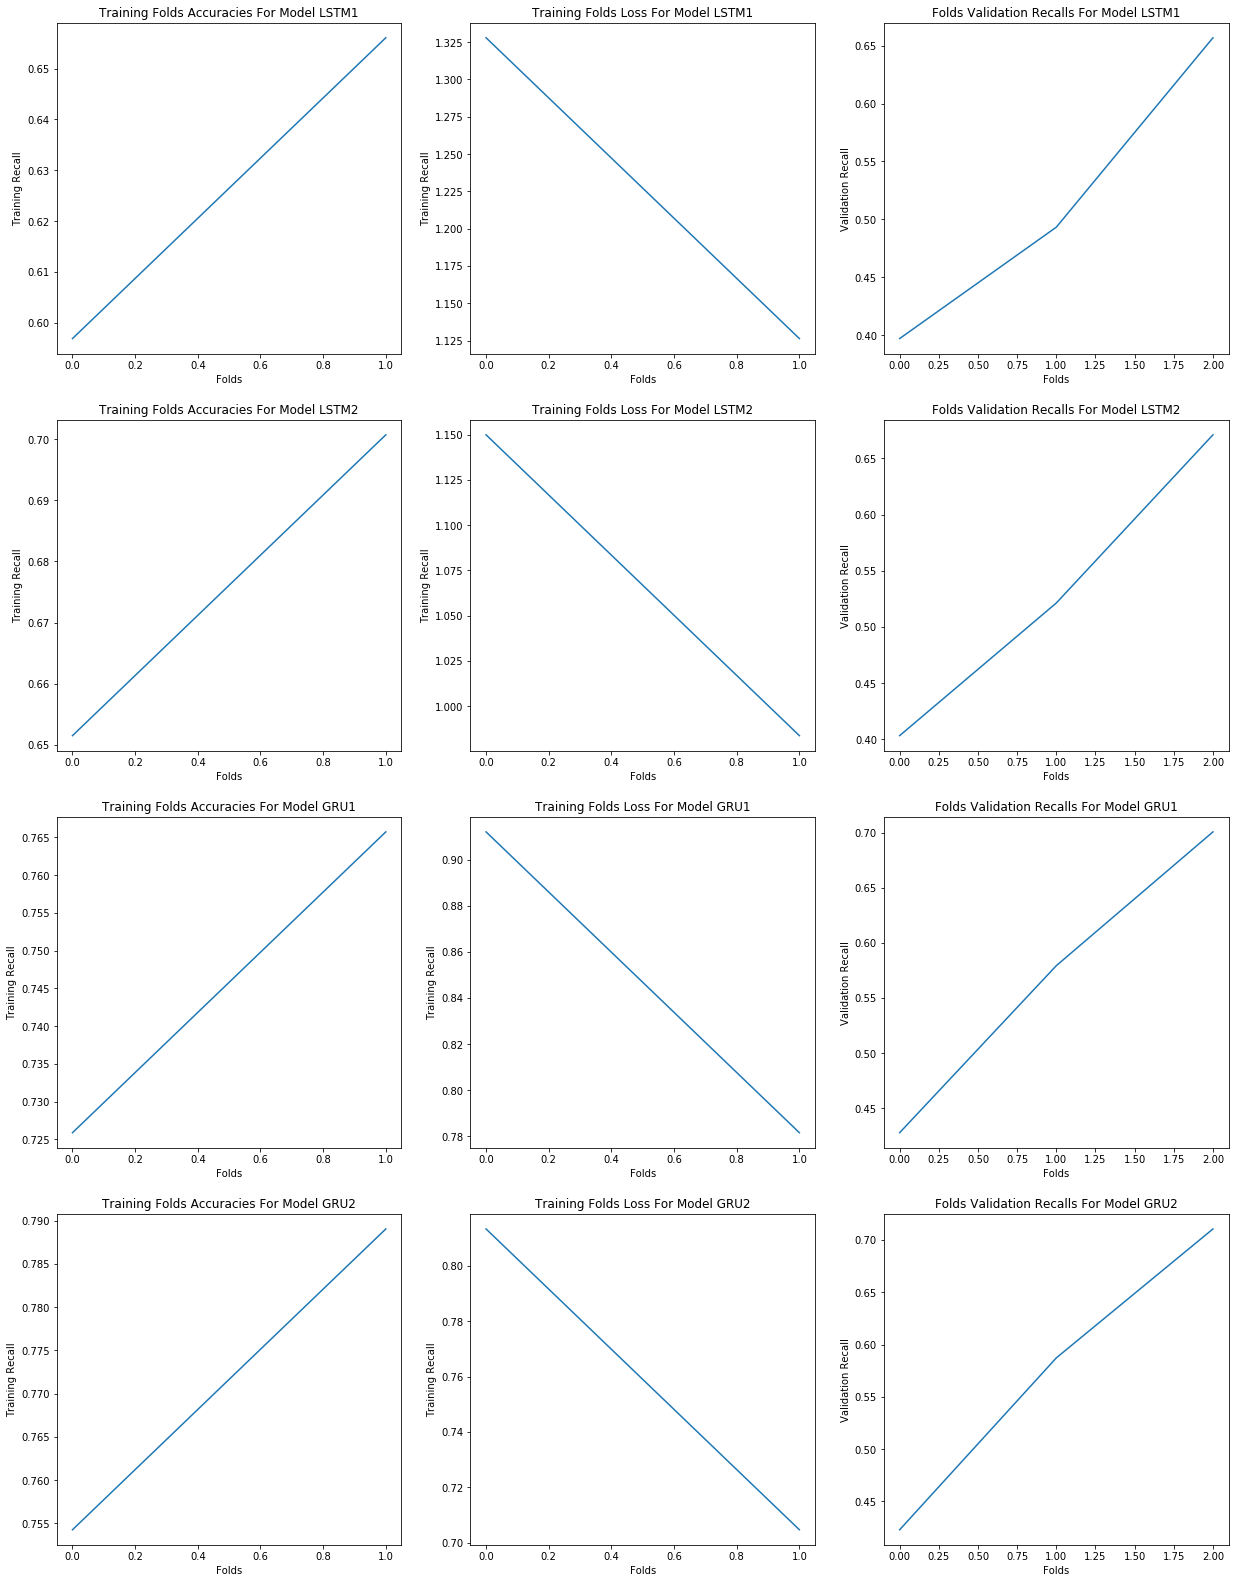

In [916]:
plt.figure(figsize = (21, 28))

plt.subplot(4, 3, 1)
plt.xlabel('Folds')
plt.ylabel('Training Recall')
plt.title('Training Folds Accuracies For Model LSTM1')
plt.plot(lstm1.history.history['acc'])

plt.subplot(4, 3, 2)
plt.xlabel('Folds')
plt.ylabel('Training Recall')
plt.title('Training Folds Loss For Model LSTM1')
plt.plot(lstm1.history.history['loss'])

plt.subplot(4, 3, 3)
plt.xlabel('Folds')
plt.ylabel('Validation Recall')
plt.title('Folds Validation Recalls For Model LSTM1')
plt.plot(lstm1_val_recall)

plt.subplot(4, 3, 4)
plt.xlabel('Folds')
plt.ylabel('Training Recall')
plt.title('Training Folds Accuracies For Model LSTM2')
plt.plot(lstm2.history.history['acc'])

plt.subplot(4, 3, 5)
plt.xlabel('Folds')
plt.ylabel('Training Recall')
plt.title('Training Folds Loss For Model LSTM2')
plt.plot(lstm2.history.history['loss'])

plt.subplot(4, 3, 6)
plt.xlabel('Folds')
plt.ylabel('Validation Recall')
plt.title('Folds Validation Recalls For Model LSTM2')
plt.plot(lstm2_val_recall)

plt.subplot(4, 3, 7)
plt.xlabel('Folds')
plt.ylabel('Training Recall')
plt.title('Training Folds Accuracies For Model GRU1')
plt.plot(gru1.history.history['acc'])

plt.subplot(4, 3, 8)
plt.xlabel('Folds')
plt.ylabel('Training Recall')
plt.title('Training Folds Loss For Model GRU1')
plt.plot(gru1.history.history['loss'])

plt.subplot(4, 3, 9)
plt.xlabel('Folds')
plt.ylabel('Validation Recall')
plt.title('Folds Validation Recalls For Model GRU1')
plt.plot(gru1_val_recall)

plt.subplot(4, 3, 10)
plt.xlabel('Folds')
plt.ylabel('Training Recall')
plt.title('Training Folds Accuracies For Model GRU2')
plt.plot(gru2.history.history['acc'])

plt.subplot(4, 3, 11)
plt.xlabel('Folds')
plt.ylabel('Training Recall')
plt.title('Training Folds Loss For Model GRU2')
plt.plot(gru2.history.history['loss'])

plt.subplot(4, 3, 12)
plt.xlabel('Folds')
plt.ylabel('Validation Recall')
plt.title('Folds Validation Recalls For Model GRU2')
plt.plot(gru2_val_recall)

<p>The above plot represents the training accuracy, training loss, and validation RECALLS for every one of the models. Every one of the models has training accuracy rising nicely while loss sinking almost at the same rate. This is accompanied by rising of validation recall. Overall, the models are behaving nicely, and no overfitting is observed to occur.</p>

In [842]:
yh_lstm1_test = np.argmax(lstm1.predict(X_test), axis = 1)
yh_lstm2_test = np.argmax(lstm2.predict(X_test), axis = 1)
yh_gru1_test = np.argmax(gru1.predict(X_test), axis = 1)
yh_gru2_test = np.argmax(gru2.predict(X_test), axis = 1)

In [843]:
lstm1_test_score = recall_score(np.argmax(y_test_ohe, axis = 1), yh_lstm1_test, average = 'micro')
lstm2_test_score = recall_score(np.argmax(y_test_ohe, axis = 1), yh_lstm2_test, average = 'micro')
gru1_test_score = recall_score(np.argmax(y_test_ohe, axis = 1), yh_gru1_test, average = 'micro')
gru2_test_score = recall_score(np.argmax(y_test_ohe, axis = 1), yh_gru2_test, average = 'micro')

In [848]:
print('The mean validation recall for the LSTM1 model is',  "{0:.5f}".format(100*np.mean(lstm1_val_recall)), 'and the STD of the fold recalls over the folds is:',"{0:.5f}".format(np.std(lstm1_val_recall)))
print('The mean validation recall for the LSTM2 model is',  "{0:.5f}".format(100*np.mean(lstm2_val_recall)), 'and the STD of the fold recalls over the folds is:',"{0:.5f}".format(np.std(lstm2_val_recall)))
print('The mean validation recall for the GRU1 model is',  "{0:.5f}".format(100*np.mean(gru1_val_recall)), 'and the STD of the fold recalls over the folds is:',"{0:.5f}".format(np.std(gru1_val_recall)))
print('The mean validation recall for the GRU2 model is',  "{0:.5f}".format(100*np.mean(gru2_val_recall)), 'and the STD of the fold recalls over the folds is:',"{0:.5f}".format(np.std(gru2_val_recall)))

The mean validation recall for the LSTM1 model is 51.57390 and the STD of the fold recalls over the folds is: 0.10724
The mean validation recall for the LSTM2 model is 53.18771 and the STD of the fold recalls over the folds is: 0.10950
The mean validation recall for the GRU1 model is 56.92936 and the STD of the fold recalls over the folds is: 0.11170
The mean validation recall for the GRU2 model is 57.35673 and the STD of the fold recalls over the folds is: 0.11777


In [851]:
print('The testing recall for model LSTM1 is found to be', "{0:.5f}".format(lstm1_test_score*100))
print('The testing recall for model LSTM2 is found to be', "{0:.5f}".format(lstm2_test_score*100))
print('The testing recall for model GRU1 is found to be', "{0:.5f}".format(gru1_test_score*100))
print('The testing recall for model GRU2 is found to be', "{0:.5f}".format(gru2_test_score*100))

The testing recall for model LSTM1 is found to be 44.99163
The testing recall for model LSTM2 is found to be 43.85608
The testing recall for model GRU1 is found to be 42.64882
The testing recall for model GRU2 is found to be 41.22639


<h3>Analysis Conclusion</h3>
<p>Despite the GRU RNN models having higher validation recall means, they have scored lower for testing performance. However, since I am using means and stds of validation recalls as well as testing performance to choose the best two models that I will perform the t-test analysis on, I choose the first model (LSTM1) and the fourth (GRU2). The LSTM1 has the best testing performance of the four models, and the GRU2 has the best validation recall. I realize that testing recall has a heavier weight on deciding about the performance of the system, but I elected to use the validation parameters in addition to testing recall in making the decision, mainly because I don't want to perform statistical testing on models made from the same unit (LSTM).</p>

In [857]:
# Number of Folds
k = 3
# Error Difference in the Validation Accuracies
d = (1 - np.array(gru2_val_recall)) - (1 - np.array(lstm1_val_recall))
# Mean of the error difference
d_bar = np.mean(d)
# Variance of the error difference across the folds
sigma_t_squared = (1/(k-1))*np.sum((d - d_bar)**2)
sigma_t = np.sqrt(sigma_t_squared)
# Confidence multiplier for 97.5% confidence and 3 folds is 4.303
t = 4.303/np.sqrt(k)
print('The range of the confidence interval goes from', "{0:.10f}".format(d_bar - t*sigma_t),'to',"{0:.10f}".format(d_bar + t*sigma_t))

The range of the confidence interval goes from -0.1428387437 to 0.0271819618


<p>Since the confidence interval passes through zero, we can say with 97.5% confidence that the model with better recall (LSTM1) is the best model between the two. Great, now we have our best model.</p>

<h2>Second RNN Chain With the Best Model</h2>
<p>The code block below utilizes the best model (LSTM1 investigated above) to attach a second LSTM unit to the output sequences of the first. The data is then fit and performance investigated.</p>
<h3>Model</h3>

In [1007]:
# Embedding for the input data
embedding_size = 100
# List to hold my RNN models
rnns = []
# Input shape
input_holder = Input(shape=(X_train.shape[1],))
# The input embedding. 
input_embedding = Embedding(top_words, embedding_size, input_length = max_overview_length)(input_holder)
# Number of classes
num_classes = len(labels)

In [1009]:
# First LSTM unit
x = LSTM(125, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(input_embedding)
# Second LSTM unit
x = LSTM(100, dropout=0.2, recurrent_dropout=0.2)(x)
# Dense Layer
x = Dense(num_classes, activation='softmax')(x)
# Compiling and fitting the model
best_model = Model(inputs = input_holder, outputs = x)
best_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
best_model.fit(X_train, y_train_ohe, epochs = 2, batch_size = 32, validation_data=(X_test, y_test_ohe))

Train on 33461 samples, validate on 8366 samples
Epoch 1/2
33461/33461 [==============================] - 757s 23ms/step - loss: 2.1121 - acc: 0.3171 - val_loss: 1.9561 - val_acc: 0.3597
Epoch 2/2
33461/33461 [==============================] - 770s 23ms/step - loss: 1.9081 - acc: 0.3710 - val_loss: 1.9105 - val_acc: 0.3726


<h3>Analysis</h3>
<p>Here I evaluate the testing recall of the model.</p>

In [1010]:
yh_best_model_test = np.argmax(best_model.predict(X_test), axis = 1)

In [1011]:
best_model_test_score = recall_score(np.argmax(y_test_ohe, axis = 1), yh_best_model_test, average = 'micro')
print('The best model with a chanined LSTM has a testing recall of:', best_model_test_score*100,'%')

The best model with a chanined LSTM has a testing recall of: 37.25794884054506 %


<h3>Training and Validation Accuracy and Loss</h3>
<p>Here I plot the training accuracy and loss, which is a little irrelevant given that my evaluation metric is recall. Keras doesn't have recall as part of their metrics for some reason, so validation is also based on accuracy.</p>

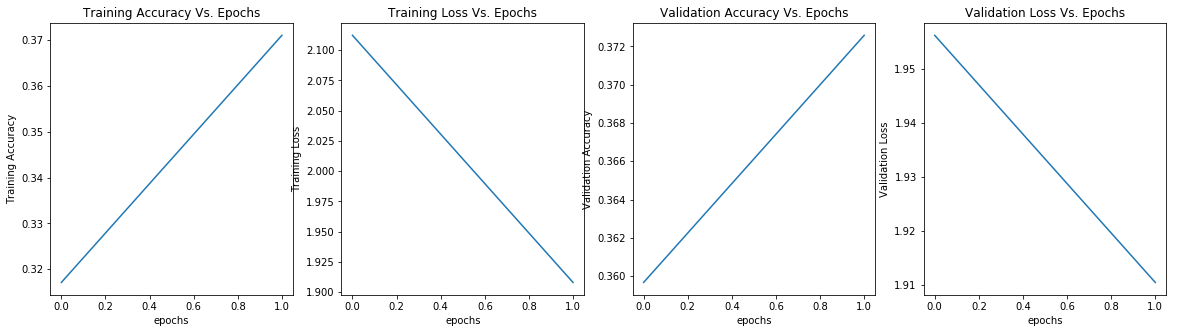

In [1012]:
plt.figure(figsize = (20, 5))

plt.subplot(1, 4, 1)
plt.xlabel('epochs')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy Vs. Epochs')
plt.plot(best_model.history.history['acc'])

plt.subplot(1, 4, 2)
plt.ylabel('Training Loss')
plt.xlabel('epochs')
plt.title('Training Loss Vs. Epochs')
plt.plot(best_model.history.history['loss'])

plt.subplot(1, 4, 3)
plt.ylabel('Validation Accuracy')
plt.xlabel('epochs')
plt.title('Validation Accuracy Vs. Epochs')
plt.plot(best_model.history.history['val_acc'])

plt.subplot(1, 4, 4)
plt.ylabel('Validation Loss')
plt.xlabel('epochs')
plt.title('Validation Loss Vs. Epochs')
plt.plot(best_model.history.history['val_loss'])

<p>This plot represents the training and validation accuracies and their associated losses. Training and validation accuracies keep rising with the epochs, and losses are sinking. No overfitting is observed to occur.</p>

<h3>Confusion Matrix</h3>
<p>Here I plot the confusion matrix for testing performance of the model.</p>

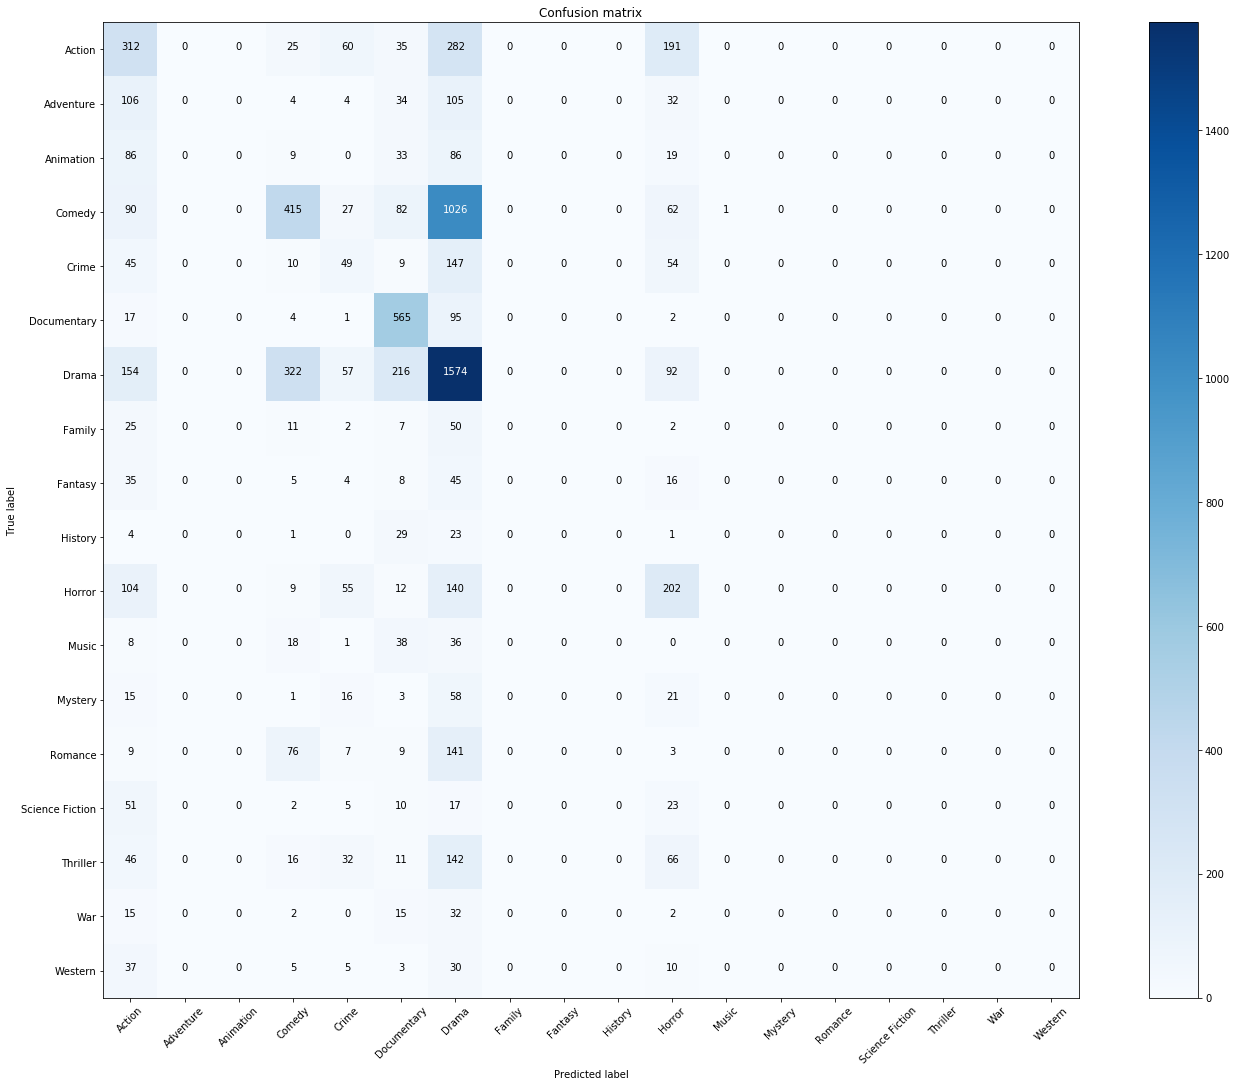

In [1013]:
plt.figure(figsize = (20, 15))
cf_best_model = mt.confusion_matrix(np.argmax(y_test_ohe, axis = 1), yh_best_model_test)
plot_confusion_matrix(cf_best_model, labels)

<p>The overall classification performance leaves much to be desired. The model is very good at classifiying Drama, which makes sense, as they make the most in the dataset. It is decent at classifying Comedy, Action, Horror, and Documentaries!.</p>

<h2>Chained Model Vs. The Best Model</h2>
<p>I am not sure if this is required. Here, I will be comparing the performance of the best model resulting from the first analysis of the 4 models with the chained model. For comparison, I am going to visualize side by side the training accuracy and loss, the validation recalls, the confusion matrices, and then perform a t-test.</p>
<h3>Model</h3>

In [976]:
# Best Model
x = LSTM(125, dropout=0.2, recurrent_dropout=0.2)(input_embedding)
x = Dense(num_classes, activation='softmax')(x)

# Chained Model
y = LSTM(125, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(input_embedding)
y = LSTM(100, dropout=0.2, recurrent_dropout=0.2)(y)
y = Dense(num_classes, activation='softmax')(y)

# Compiling the models
chained = Model(inputs = input_holder, outputs = y)
best_non_chained = Model(inputs = input_holder, outputs = x)

chained.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
best_non_chained.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [977]:
k_folds = 3
# Validation accuracies lists for the RNN models
chained_val_recall = []
best_non_chained_val_recall = []


# Stratified K-Folds as argued for above
cv2 = StratifiedKFold(n_splits = k_folds)
# Looping through the K-splits
for train, validation in cv2.split(X_train, np.zeros(shape=(X_train.shape[0], 1))):
    # Splitting for training/validation
    k_x_train, k_x_validation = X_train[train], X_train[validation]
    k_y_train, k_y_validation = y_train_ohe[train], y_train_ohe[validation]
    # Fitting the data
    chained.fit(k_x_train, k_y_train, epochs = 2, batch_size = 32)
    best_non_chained.fit(k_x_train, k_y_train, epochs = 2, batch_size = 32)
    # Evaluating for the evaluation metric of the dataset - Micro Recall
    
    # Chained
    yhat_chained = chained.predict(k_x_validation)
    yhat_chained = np.argmax(yhat_chained, axis = 1)
    chained_score = recall_score(np.argmax(k_y_validation, axis=1), yhat_chained, average='micro')
    chained_val_recall.append(chained_score)
    # Best non-chained
    yhat_best_non_chained = best_non_chained.predict(k_x_validation)
    yhat_best_non_chained = np.argmax(yhat_best_non_chained, axis = 1)
    best_non_chained_score = recall_score(np.argmax(k_y_validation, axis=1), yhat_best_non_chained, average='micro')
    best_non_chained_val_recall.append(best_non_chained_score)

Epoch 1/2
22307/22307 [==============================] - 451s 20ms/step - loss: 1.7419 - acc: 0.4730
Epoch 2/2
22307/22307 [==============================] - 469s 21ms/step - loss: 1.4714 - acc: 0.5567
Epoch 1/2
22307/22307 [==============================] - 329s 15ms/step - loss: 1.7283 - acc: 0.4881
Epoch 2/2
22307/22307 [==============================] - 318s 14ms/step - loss: 1.4035 - acc: 0.5842
Epoch 1/2
22307/22307 [==============================] - 502s 22ms/step - loss: 1.5296 - acc: 0.5390
Epoch 2/2
22307/22307 [==============================] - 506s 23ms/step - loss: 1.4036 - acc: 0.5790
Epoch 1/2
22307/22307 [==============================] - 322s 14ms/step - loss: 1.3820 - acc: 0.5870
Epoch 2/2
22307/22307 [==============================] - 344s 15ms/step - loss: 1.2574 - acc: 0.6199
Epoch 1/2
22308/22308 [==============================] - 550s 25ms/step - loss: 1.3357 - acc: 0.5983
Epoch 2/2
22308/22308 [==============================] - 505s 23ms/step - loss: 1.2087 - ac

<h3>Training Accuracy, Loss, and Validation Recall plots</h3>

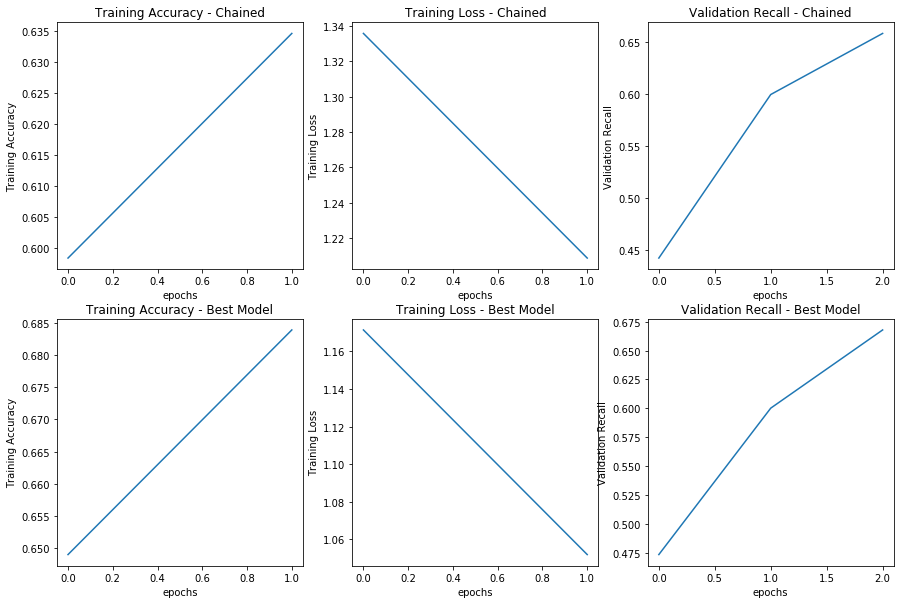

In [990]:
plt.figure(figsize = (15, 10))

plt.subplot(2, 3, 1)
plt.xlabel('epochs')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy - Chained')
plt.plot(chained.history.history['acc'])

plt.subplot(2, 3, 2)
plt.ylabel('Training Loss')
plt.xlabel('epochs')
plt.title('Training Loss - Chained')
plt.plot(chained.history.history['loss'])

plt.subplot(2, 3, 3)
plt.ylabel('Validation Recall')
plt.xlabel('epochs')
plt.title('Validation Recall - Chained')
plt.plot(chained_val_recall)

plt.subplot(2, 3, 4)
plt.xlabel('epochs')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy - Best Model')
plt.plot(best_non_chained.history.history['acc'])

plt.subplot(2, 3, 5)
plt.ylabel('Training Loss')
plt.xlabel('epochs')
plt.title('Training Loss - Best Model')
plt.plot(best_non_chained.history.history['loss'])

plt.subplot(2, 3, 6)
plt.ylabel('Validation Recall')
plt.xlabel('epochs')
plt.title('Validation Recall - Best Model')
plt.plot(best_non_chained_val_recall)

<p>It can be seen from the above plots that the training accuracy, training loss, and validation recalls are almost identical for both models. The training accuracy keeps on rising along with validation recall. No overfitting is observed to occur. Training loss sinks with the epochs, too.</p>

<h3>Testing Performance and Confusion Matrices</h3>

In [993]:
yhat_chained = np.argmax(chained.predict(X_test), axis = 1)
yhat_best_model = np.argmax(best_non_chained.predict(X_test), axis = 1)

In [994]:
chained_test_score = recall_score(np.argmax(y_test_ohe, axis = 1), yhat_chained, average = 'micro')
non_chained_best_model_test_score = recall_score(np.argmax(y_test_ohe, axis = 1), yhat_best_model, average = 'micro')
cf_chained = mt.confusion_matrix(np.argmax(y_test_ohe, axis = 1), yhat_chained)
cf_non_chained = mt.confusion_matrix(np.argmax(y_test_ohe, axis = 1), yhat_best_model)

In [996]:
print('The test recall for the chained LSTM model is:', chained_test_score*100)
print('The test recall for the best LSTM model is:', non_chained_best_model_test_score*100)

The test recall for the chained LSTM model is: 47.28663638536935
The test recall for the best LSTM model is: 46.37819746593354


<p>The testing recall for the chained LSTM model is slightly higher than that for the best model.</p>

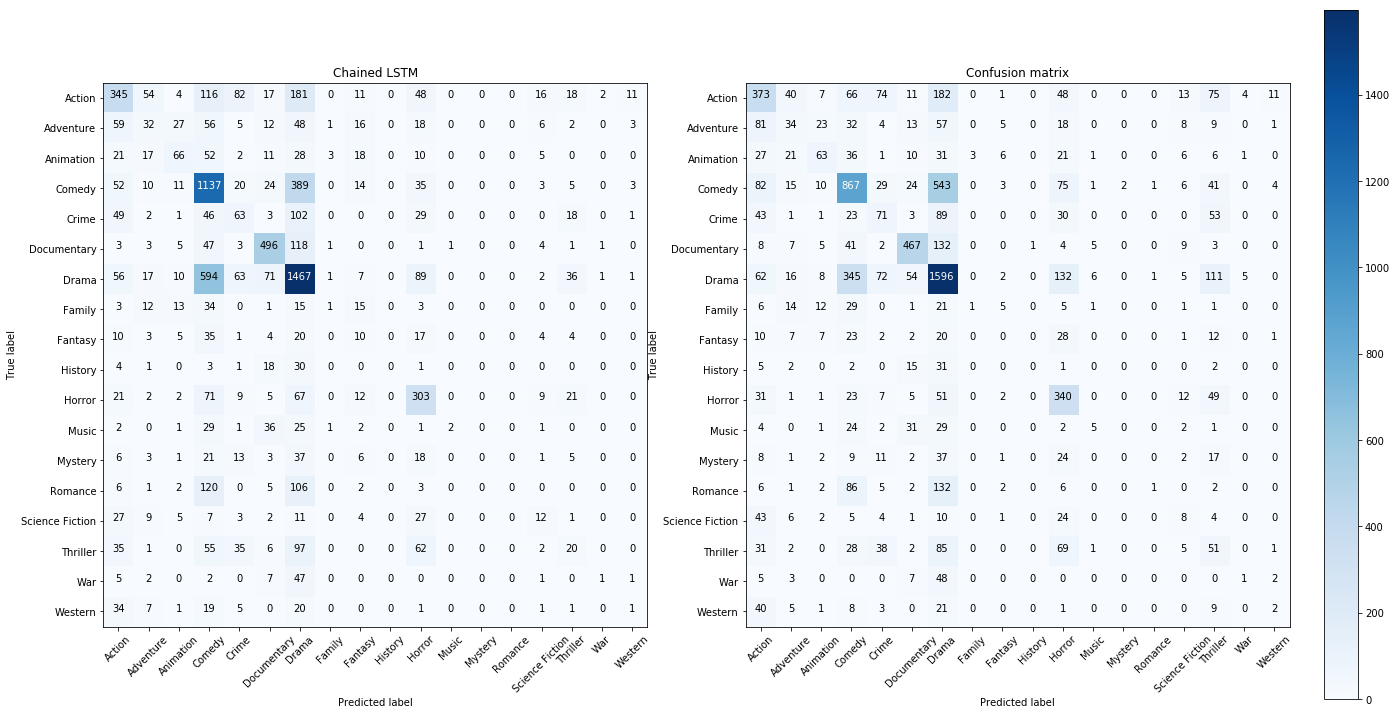

In [1005]:
plt.figure(figsize = (20, 10))
plt.subplot(1,2,1)
plot_confusion_matrix(cf_chained, labels, title='Chained LSTM')
plt.subplot(1,2,2)
plot_confusion_matrix(cf_non_chained, labels)

<p>The chained LSTM model differs in classification performance compared with the best model. The chained model is better at classifying Comedy by a good margin, they both classify documentaries just the same, and they are quite similar in classifying Action and Horror. </p>

<h3>t-test</h3>

In [1014]:
# Number of Folds
k = 3
# Error Difference in the Validation Accuracies
d = (1 - np.array(chained_val_recall)) - (1 - np.array(best_non_chained_val_recall))
# Mean of the error difference
d_bar = np.mean(d)
# Variance of the error difference across the folds
sigma_t_squared = (1/(k-1))*np.sum((d - d_bar)**2)
sigma_t = np.sqrt(sigma_t_squared)
# Confidence multiplier for 97.5% confidence and 3 folds is 4.303
t = 4.303/np.sqrt(k)
print('The range of the confidence interval goes from', "{0:.10f}".format(d_bar - t*sigma_t),'to',"{0:.10f}".format(d_bar + t*sigma_t))

The range of the confidence interval goes from -0.0246238813 to 0.0524171909


<p>Considering the above, it can be said with 97.5% accuracy that the chained LSTM model is better than the best model identified in the first analysis, as it has a higher testing recall, which was calculated above.</p>

<h1>Conclusion</h1>
<p>The highest testing recall between all the models analyzed was found to be ~47%, which is far less than the 80% threshold set for the usability of the classification task in a real life application. However, I think there is room for many imporvements in the model. I think the data could be collected in a more intelligent way, some of the genres merged in a single genre to ease the task, and perform an involved grid search for hyperparameter tuning (which wasn't done due to time and computational requirements). I don't have anything to back up my words, but I think recall could rise significantly given enough time to work the problem. Also, I think Macro recall might have been a better metric. It would be much harsher on the performance of classification, but it would be a better representation of reality.</p>